In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import confusion_matrix
from scipy.stats import mstats

In [2]:
transaction_df = pd.read_csv('data/CC_Fraud_Txndata_Final.csv')
transaction_df

,distance_from_last_transaction,ratio_to_median_purchase_price,Weekday,Days since last txn,Has secondary user,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,0.311140,1.945940,7,12,1,1,1,0,0,0
1,0.175592,1.294219,2,5,0,1,0,0,0,0
2,0.805153,0.427715,7,4,0,1,0,0,1,0
3,5.600044,0.362663,7,7,0,1,1,0,1,0
4,0.566486,2.222767,6,11,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
999995,0.112651,1.626798,1,3,0,1,1,0,0,0
999996,2.683904,2.778303,5,14,0,1,1,0,0,0
999997,1.472687,0.218075,7,11,1,1,1,0,1,0
999998,0.242023,0.475822,7,2,0,1,0,0,1,0


In [3]:
transaction_df.rename(columns={
    'Weekday'               : 'weekday', 
    'Days since last txn'   : 'days_since_last_txn', 
    'Has secondary user'    : 'secondary_user'
    }, inplace=True)

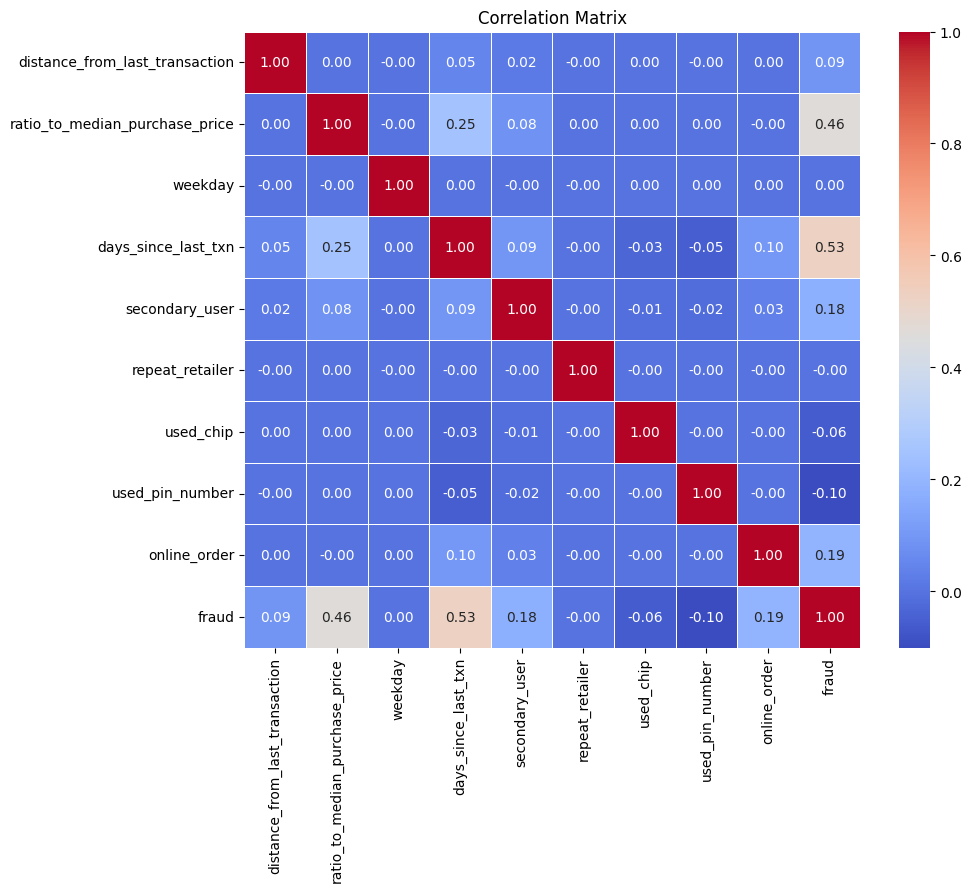

In [4]:
correlation_matrix = transaction_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

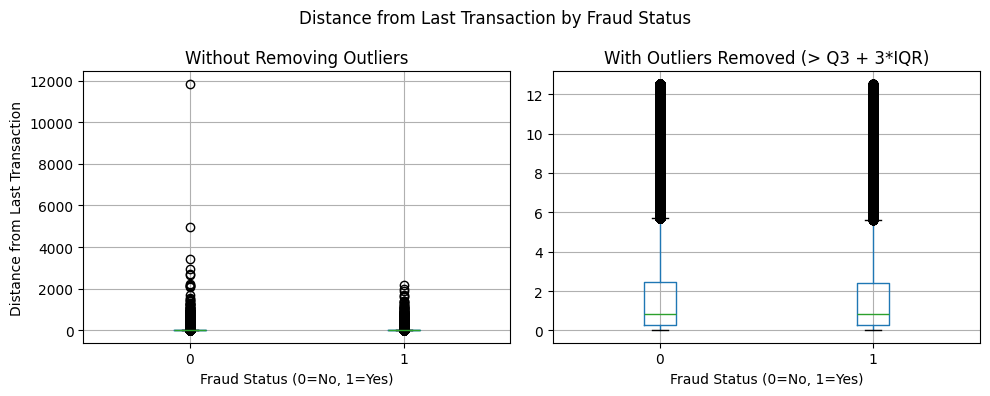

In [5]:
Q1 = transaction_df['distance_from_last_transaction'].quantile(0.25)
Q3 = transaction_df['distance_from_last_transaction'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 3*IQR  # Using 3*IQR instead of typical 1.5*IQR to keep more data

filtered_df = transaction_df[transaction_df['distance_from_last_transaction'] <= upper_bound]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

transaction_df.boxplot(column='distance_from_last_transaction', by='fraud', ax=axes[0])
axes[0].set_title('Without Removing Outliers')
axes[0].set_xlabel('Fraud Status (0=No, 1=Yes)')
axes[0].set_ylabel('Distance from Last Transaction')

filtered_df.boxplot(column='distance_from_last_transaction', by='fraud', ax=axes[1])
axes[1].set_title('With Outliers Removed (> Q3 + 3*IQR)')
axes[1].set_xlabel('Fraud Status (0=No, 1=Yes)')
axes[1].set_ylabel('')

fig.suptitle('Distance from Last Transaction by Fraud Status')

plt.tight_layout()
plt.show()

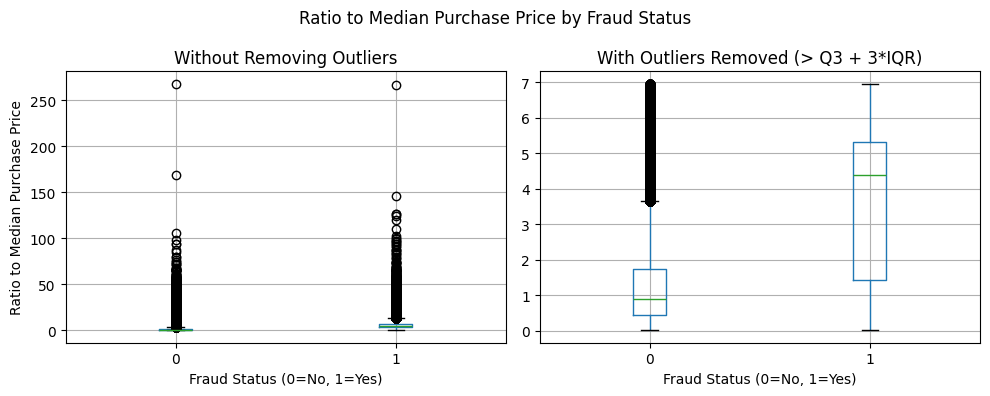

In [6]:
Q1 = transaction_df['ratio_to_median_purchase_price'].quantile(0.25)
Q3 = transaction_df['ratio_to_median_purchase_price'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 3*IQR  # Using 3*IQR instead of typical 1.5*IQR to keep more data

filtered_df = transaction_df[transaction_df['ratio_to_median_purchase_price'] <= upper_bound]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

transaction_df.boxplot(column='ratio_to_median_purchase_price', by='fraud', ax=axes[0])
axes[0].set_title('Without Removing Outliers')
axes[0].set_xlabel('Fraud Status (0=No, 1=Yes)')
axes[0].set_ylabel('Ratio to Median Purchase Price')

filtered_df.boxplot(column='ratio_to_median_purchase_price', by='fraud', ax=axes[1])
axes[1].set_title('With Outliers Removed (> Q3 + 3*IQR)')
axes[1].set_xlabel('Fraud Status (0=No, 1=Yes)')
axes[1].set_ylabel('')

fig.suptitle('Ratio to Median Purchase Price by Fraud Status')

plt.tight_layout()
plt.show()

<Figure size 500x400 with 0 Axes>

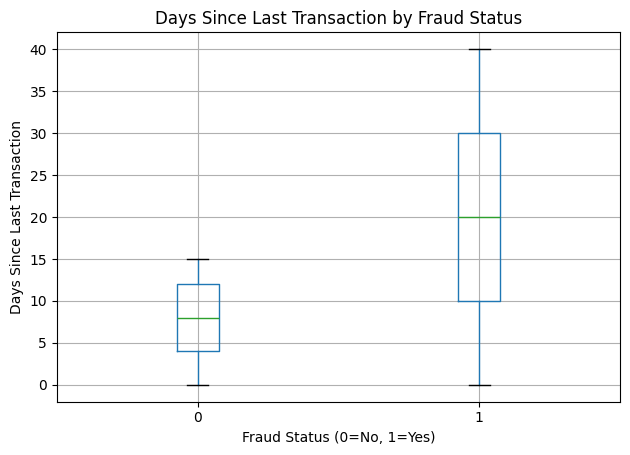

In [7]:
plt.figure(figsize=(5, 4))
transaction_df.boxplot(column='days_since_last_txn', by='fraud')

plt.title('Days Since Last Transaction by Fraud Status')
plt.suptitle('')
plt.xlabel('Fraud Status (0=No, 1=Yes)')
plt.ylabel('Days Since Last Transaction')

plt.tight_layout()
plt.show()

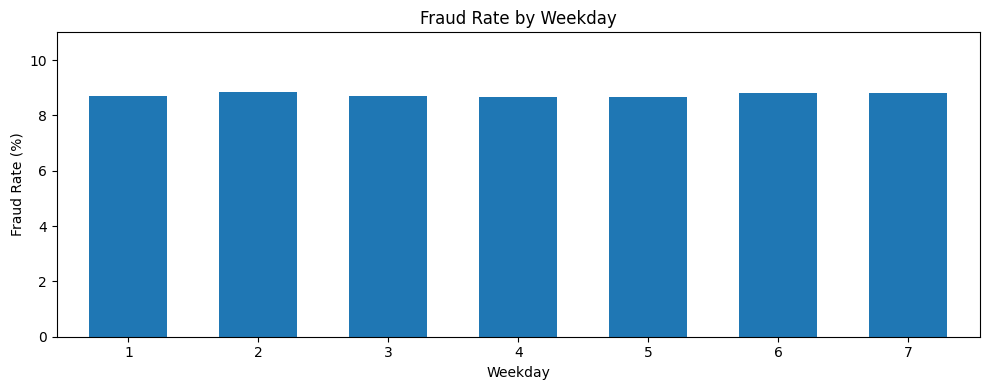

In [8]:
fraud_by_weekday = transaction_df.groupby(['weekday', 'fraud']).size().unstack()
fraud_by_weekday.rename(columns={0: 'Non_Fraud', 1: 'Fraud'}, inplace=True)
fraud_by_weekday['fraud_rate'] = np.round(fraud_by_weekday['Fraud'] / fraud_by_weekday.sum(axis=1) * 100, 2)

fraud_by_weekday['fraud_rate'].plot(kind='bar', figsize=(10, 4), width=0.6)

plt.title('Fraud Rate by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Fraud Rate (%)')
plt.xticks(rotation=0)
plt.ylim(0,11)

plt.tight_layout()
plt.show()

In [9]:
boolean_cols = ['secondary_user', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']

results = {}

for col in boolean_cols:
    ratio = np.round(transaction_df[transaction_df[col]==1].shape[0] / 1000000 * 100, 2)
    results[col] = ratio

pd.DataFrame(results, index=['Yes Percent of All Transaction']).T

,Yes Percent of All Transaction
secondary_user,11.75
repeat_retailer,88.15
used_chip,35.04
used_pin_number,10.06
online_order,65.06


In [10]:
boolean_cols = ['secondary_user', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']

results = []
for col in boolean_cols:
    TN, FP, FN, TP = confusion_matrix(transaction_df['fraud'], transaction_df[col]).ravel()
    results.append({'TN': TN, 'FP': FP, 'FN': FN, 'TP': TP})

result_df = pd.DataFrame(results, index=boolean_cols)
result_df['Accuracy'] = (result_df['TN'] + result_df['TP']) / (result_df['TN'] + result_df['TP'] + result_df['FN'] + result_df['FP'])
result_df['Precision'] = result_df['TP'] / (result_df['TP'] + result_df['FP'])
result_df['Recall'] = result_df['TP'] / (result_df['TP'] + result_df['FN'])
result_df['F1_Score'] = 2 * (result_df['Precision'] * result_df['Recall']) / (result_df['Precision'] + result_df['Recall'])

result_df

,TN,FP,FN,TP,Accuracy,Precision,Recall,F1_Score
secondary_user,821337,91260,61182,26221,0.847558,0.223194,0.300001,0.255959
repeat_retailer,107986,804611,10478,76925,0.184911,0.087262,0.880119,0.158782
used_chip,584608,327989,64993,22410,0.607018,0.063956,0.256399,0.102375
used_pin_number,812262,100335,87130,273,0.812535,0.002714,0.003123,0.002904
online_order,344756,567841,4692,82711,0.427467,0.127140,0.946318,0.224163


In [11]:
secondary_user_by_fraud = transaction_df.groupby(['fraud'])['secondary_user'].value_counts(normalize=True).unstack()
secondary_user_by_fraud.rename(columns={0: 'secondary_user_n', 1: 'secondary_user_y'}, inplace=True)
secondary_user_by_fraud = secondary_user_by_fraud * 100

fraud_by_second_user = transaction_df.groupby(['secondary_user'])['fraud'].value_counts(normalize=True).unstack()
fraud_by_second_user.rename(columns={0: 'fraud_n', 1: 'fraud_y'}, inplace=True)
fraud_by_second_user = fraud_by_second_user * 100

display(secondary_user_by_fraud)
display(fraud_by_second_user)

secondary_user,secondary_user_n,secondary_user_y
fraud,,
0,89.999967,10.000033
1,69.999886,30.000114


fraud,fraud_n,fraud_y
secondary_user,,
0,93.067345,6.932655
1,77.680646,22.319354


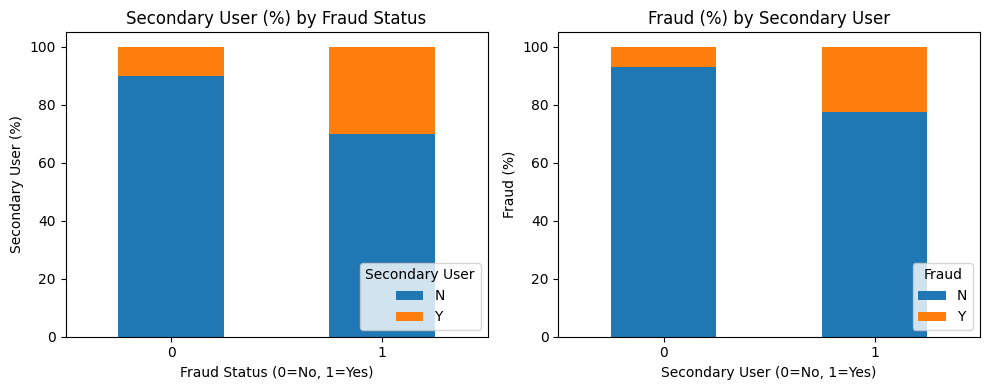

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

secondary_user_by_fraud.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Secondary User (%) by Fraud Status')
axes[0].set_xlabel('Fraud Status (0=No, 1=Yes)')
axes[0].set_ylabel('Secondary User (%)')
axes[0].legend(['N', 'Y'], title='Secondary User', loc='lower right')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

fraud_by_second_user.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Fraud (%) by Secondary User')
axes[1].set_xlabel('Secondary User (0=No, 1=Yes)')
axes[1].set_ylabel('Fraud (%)')
axes[1].legend(['N', 'Y'], title='Fraud', loc='lower right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [13]:
repeat_retailer_by_fraud = transaction_df.groupby(['fraud'])['repeat_retailer'].value_counts(normalize=True).unstack()
repeat_retailer_by_fraud.rename(columns={0: 'repeat_retailer_n', 1: 'repeat_retailer_y'}, inplace=True)
repeat_retailer_by_fraud = repeat_retailer_by_fraud * 100

fraud_by_repeat_retailer = transaction_df.groupby(['repeat_retailer'])['fraud'].value_counts(normalize=True).unstack()
fraud_by_repeat_retailer.rename(columns={0: 'fraud_n', 1: 'fraud_y'}, inplace=True)
fraud_by_repeat_retailer = fraud_by_repeat_retailer * 100

display(repeat_retailer_by_fraud)
display(fraud_by_repeat_retailer)


repeat_retailer,repeat_retailer_n,repeat_retailer_y
fraud,,
0,11.832824,88.167176
1,11.988147,88.011853


fraud,fraud_n,fraud_y
repeat_retailer,,
0,91.155119,8.844881
1,91.273754,8.726246


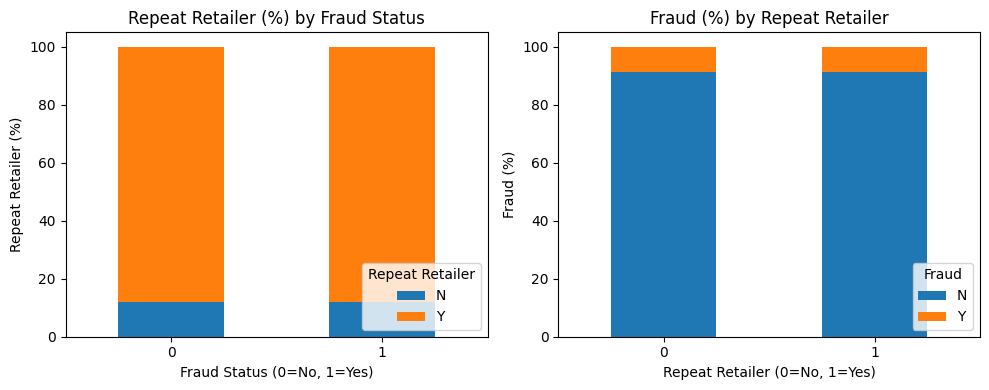

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

repeat_retailer_by_fraud.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Repeat Retailer (%) by Fraud Status')
axes[0].set_xlabel('Fraud Status (0=No, 1=Yes)')
axes[0].set_ylabel('Repeat Retailer (%)')
axes[0].legend(['N', 'Y'], title='Repeat Retailer', loc='lower right')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

fraud_by_repeat_retailer.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Fraud (%) by Repeat Retailer')
axes[1].set_xlabel('Repeat Retailer (0=No, 1=Yes)')
axes[1].set_ylabel('Fraud (%)')
axes[1].legend(['N', 'Y'], title='Fraud', loc='lower right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [15]:
used_chip_by_fraud = transaction_df.groupby(['fraud'])['used_chip'].value_counts(normalize=True).unstack()
used_chip_by_fraud.rename(columns={0: 'used_chip_n', 1: 'used_chip_y'}, inplace=True)
used_chip_by_fraud = used_chip_by_fraud * 100

fraud_by_used_chip = transaction_df.groupby(['used_chip'])['fraud'].value_counts(normalize=True).unstack()
fraud_by_used_chip.rename(columns={0: 'fraud_n', 1: 'fraud_y'}, inplace=True)
fraud_by_used_chip = fraud_by_used_chip * 100

display(used_chip_by_fraud)
display(fraud_by_used_chip)

used_chip,used_chip_n,used_chip_y
fraud,,
0,64.059820,35.940180
1,74.360148,25.639852


fraud,fraud_n,fraud_y
used_chip,,
0,89.994935,10.005065
1,93.604434,6.395566


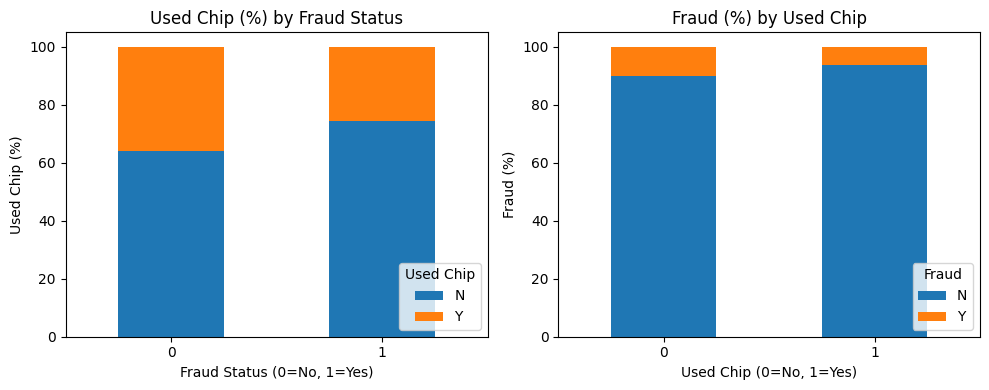

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

used_chip_by_fraud.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Used Chip (%) by Fraud Status')
axes[0].set_xlabel('Fraud Status (0=No, 1=Yes)')
axes[0].set_ylabel('Used Chip (%)')
axes[0].legend(['N', 'Y'], title='Used Chip', loc='lower right')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

fraud_by_used_chip.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Fraud (%) by Used Chip')
axes[1].set_xlabel('Used Chip (0=No, 1=Yes)')
axes[1].set_ylabel('Fraud (%)')
axes[1].legend(['N', 'Y'], title='Fraud', loc='lower right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [17]:
used_pin_number_by_fraud = transaction_df.groupby(['fraud'])['used_pin_number'].value_counts(normalize=True).unstack()
used_pin_number_by_fraud.rename(columns={0: 'used_pin_number_n', 1: 'used_pin_number_y'}, inplace=True)
used_pin_number_by_fraud = used_pin_number_by_fraud * 100

fraud_by_used_pin_number = transaction_df.groupby(['used_pin_number'])['fraud'].value_counts(normalize=True).unstack()
fraud_by_used_pin_number.rename(columns={0: 'fraud_n', 1: 'fraud_y'}, inplace=True)
fraud_by_used_pin_number = fraud_by_used_pin_number * 100

display(used_pin_number_by_fraud)
display(fraud_by_used_pin_number)

used_pin_number,used_pin_number_n,used_pin_number_y
fraud,,
0,89.005552,10.994448
1,99.687654,0.312346


fraud,fraud_n,fraud_y
used_pin_number,,
0,90.312344,9.687656
1,99.728650,0.271350


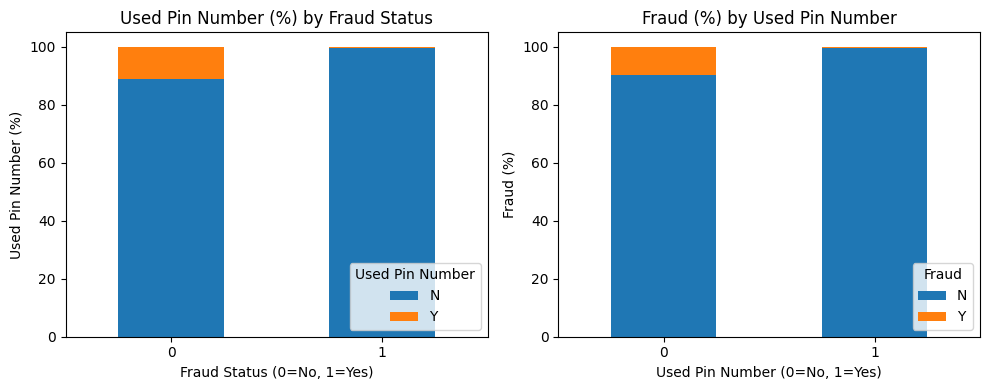

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

used_pin_number_by_fraud.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Used Pin Number (%) by Fraud Status')
axes[0].set_xlabel('Fraud Status (0=No, 1=Yes)')
axes[0].set_ylabel('Used Pin Number (%)')
axes[0].legend(['N', 'Y'], title='Used Pin Number', loc='lower right')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

fraud_by_used_pin_number.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Fraud (%) by Used Pin Number')
axes[1].set_xlabel('Used Pin Number (0=No, 1=Yes)')
axes[1].set_ylabel('Fraud (%)')
axes[1].legend(['N', 'Y'], title='Fraud', loc='lower right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [19]:
online_order_by_fraud = transaction_df.groupby(['fraud'])['online_order'].value_counts(normalize=True).unstack()
online_order_by_fraud.rename(columns={0: 'online_order_n', 1: 'online_order_y'}, inplace=True)
online_order_by_fraud = online_order_by_fraud * 100

fraud_by_online_order = transaction_df.groupby(['online_order'])['fraud'].value_counts(normalize=True).unstack()
fraud_by_online_order.rename(columns={0: 'fraud_n', 1: 'fraud_y'}, inplace=True)
fraud_by_online_order = fraud_by_online_order * 100

display(online_order_by_fraud)
display(fraud_by_online_order)

online_order,online_order_n,online_order_y
fraud,,
0,37.777464,62.222536
1,5.368237,94.631763


fraud,fraud_n,fraud_y
online_order,,
0,98.657311,1.342689
1,87.286028,12.713972


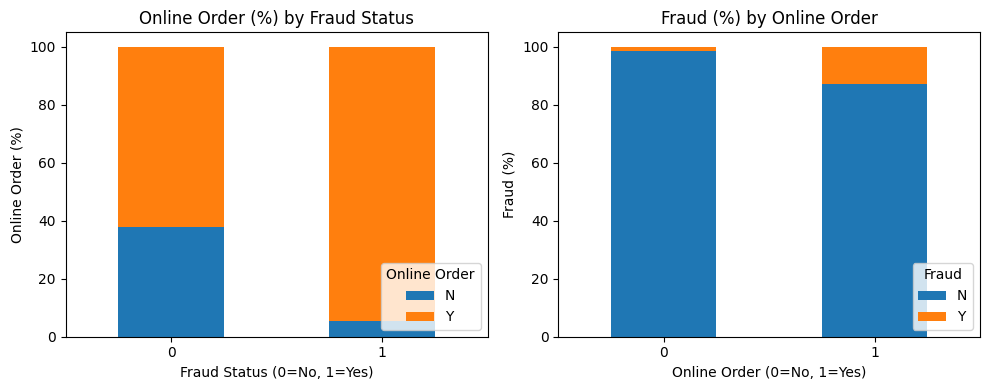

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

online_order_by_fraud.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Online Order (%) by Fraud Status')
axes[0].set_xlabel('Fraud Status (0=No, 1=Yes)')
axes[0].set_ylabel('Online Order (%)')
axes[0].legend(['N', 'Y'], title='Online Order', loc='lower right')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

fraud_by_online_order.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Fraud (%) by Online Order')
axes[1].set_xlabel('Online Order (0=No, 1=Yes)')
axes[1].set_ylabel('Fraud (%)')
axes[1].legend(['N', 'Y'], title='Fraud', loc='lower right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [21]:
Q1_distance = transaction_df['distance_from_last_transaction'].quantile(0.25)
Q3_distance = transaction_df['distance_from_last_transaction'].quantile(0.75)
IQR_distance = Q3_distance - Q1_distance
upper_bound_distance = Q3_distance + 3*IQR_distance

Q1_price = transaction_df['ratio_to_median_purchase_price'].quantile(0.25)
Q3_price = transaction_df['ratio_to_median_purchase_price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
upper_bound_price = Q3_price + 3*IQR_price

modeling_df = transaction_df[(transaction_df['distance_from_last_transaction'] < upper_bound_distance) 
                             & (transaction_df['ratio_to_median_purchase_price'] < upper_bound_price)].copy()

X = modeling_df.drop(columns='fraud')
y = modeling_df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

model = LogisticRegression(max_iter=10000)
sfs = SequentialFeatureSelector(model, n_features_to_select=5, direction='backward', scoring='f1', cv=5)
sfs.fit(X_train, y_train)

selected_features = sfs.get_support(indices=True)
modeling_df.columns[selected_features]

Index(['ratio_to_median_purchase_price', 'days_since_last_txn',
       'secondary_user', 'used_pin_number', 'online_order'],
      dtype='object')

In [22]:
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)

model.fit(X_train_sfs, y_train)

score = model.score(X_test_sfs, y_test)

conf_mat = confusion_matrix(y_test, model.predict(X_test_sfs))
conf_mat

array([[207410,    629],
       [  4098,   9118]])

In [23]:
TN, FP, FN, TP = conf_mat.ravel()
 
Accuracy = (TN + TP)/(TN + TP + FN + FP)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1_Score = 2 * (Precision * Recall) / (Precision + Recall)

print(f'True Negative   : {TN}')
print(f'True Positive   : {TP}')
print(f'False Negative  : {FN}')
print(f'False Positive: : {FP}')

print(f'Accuracy        : {Accuracy:.3f}')
print(f'Precision       : {Precision:.3f}')
print(f'Recall          : {Recall:.3f}')
print(f'F1_Score        : {F1_Score:.3f}')

True Negative   : 207410
True Positive   : 9118
False Negative  : 4098
False Positive: : 629
Accuracy        : 0.979
Precision       : 0.935
Recall          : 0.690
F1_Score        : 0.794
